# Лабораторная работа 1
## Мохляков П.А
### Импортируем библиотки 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import random_split
import pandas as pd
import shutil

### Указываем пути и лейблы

In [37]:
images_dir = 'dataset/flower_images/flower_images'
dataset_dir = 'dataset/dataset'
labels = ['phlox', 
          'rose', 
          'calendula', 
          'iris', 
          'leucanthemum_maximum', 
          'campanula', 
          'viola', 
          'rudbeckia_laciniata',
          'peony',
          'aquilegia',
#           'rhododendron',
#           'passiflora',
#           'tulip',
#           'water_lily',
#           'lilium',
#           'veronica_chamaedrys',
#           'cosmos',
#           'aster_annual',
#           'aster_perennial',
#           'snowdrop'
         ]



### Создаем папку датасета, если не создана и очищаем ее, если работали с ней

In [38]:
#Создаем папку для датасета
if not os.path.exists(dataset_dir):
    os.mkdir(dataset_dir)
#Проходим по всем файлам в папке
for filename in os.listdir(dataset_dir):
    #Полный путь
    file_path = os.path.join(dataset_dir, filename)
    try:
        #Удаляем файл
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        #Удаляем папку
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

### Создаем папки для классов и копируем файлы

In [39]:
#читаем CSV
data_csv = pd.read_csv(images_dir + '/flower_labels.csv')
#проходи по данным
for index, row in data_csv.iterrows():
    #Путь до папки
    label_dir = os.path.join(dataset_dir, labels[row['label']])
    #Создаем если ее нет
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
    #Копируем изображение
    shutil.copyfile(os.path.join(images_dir, row['file']), os.path.join(label_dir, row['file']))

### Создаем датасеты

In [41]:
# Генерируем сид
torch.manual_seed(time.time())
#Преобразование картинок и агментация отражением
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
#Загружаем датасет
database = datasets.ImageFolder(dataset_dir, transform=data_transform)
#размер данных для валидации
val_size = 30 
#размер данных для тренировки
training_size = len(database) - val_size 
#делим на валидационный и тренировочный датасет
train_ds, val_ds = random_split(database, [training_size, val_size]) 
print('Num training images: ', len(train_ds))
print('Num test images: ', len(val_ds))
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

Num training images:  180
Num test images:  30


### Создаем даталоудеры и список классов

In [42]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4, 
                                           num_workers=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=4, 
                                           num_workers=4, shuffle=True)
dataloaders = {'train':train_loader, 'val':val_loader}
class_names = database.classes

### Выводим пример батча

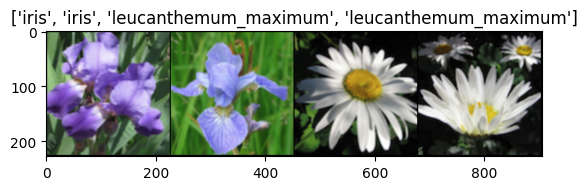

In [57]:
def imshow(inp, title=None):
    #Меняем shape с (3,size_im,size_im) на (size_im,size_im,3)
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()
#Берем обин батч
inputs, classes = next(iter(dataloaders['train']))

#Преобразовываем батч в грид (4 картики преобразовываем в 1)
out = torchvision.utils.make_grid(inputs)
#Выводим батч
imshow(out, title=[class_names[x] for x in classes])

### Функция тренировки

In [47]:
#Проверяем есть ли куда
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #время начала
    since = time.time()
    
    #копия модели и точность
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #Каждую эпоху
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Для тренировочной и валидационной выборки
        for phase in ['train', 'val']:
            #Устанавливаем модель в состояние тренировки или исполнения
            if phase == 'train':
                model.train() 
            else:
                model.eval()   
            #Ошибка и количество совпадений
            running_loss = 0.0
            running_corrects = 0

            # Для каждого батча
            for inputs, labels in dataloaders[phase]:
                #Переводим тенсоры для cuda или cpu
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуляем грабиент
                optimizer.zero_grad()

                #Если в состоянии тренировки то включаем подсчет градиентов
                with torch.set_grad_enabled(phase == 'train'):
                    #Вывод модели
                    outputs = model(inputs)
                    #argmax по dim=1
                    _, preds = torch.max(outputs, 1)
                    #считаем ошибку
                    loss = criterion(outputs, labels)

                    # Если тренерумся, то обновляем веса
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Ошибка и количество совпадений всего
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #Обновляем скорость обучения
            if phase == 'train':
                scheduler.step()
            # Ошибка и количество совпадений средние за эпоху
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Обновляем лучшие веса
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    #Подсчет выремени и вывод лучшей точности
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Загружаем лучшие веса
    model.load_state_dict(best_model_wts)
    # Возвращаем модель
    return model

### Выводим пример работы модели

In [48]:
def visualize_model(model, num_images=10):
    #Запоминаем состояние модели
    was_training = model.training
    #Переводим в состояние исполнения модели
    model.eval()
    #Счетчик изображений
    images_so_far = 0
    #Задачем размер фигуры
    fig = plt.figure(figsize=(6,10))
    #Отключаем расчет градиента
    with torch.no_grad():
        #Проходим по валидационному датасету
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #Переводим тенсоры для cuda или cpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #Получаем вывод и делаем argmax
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            #Проходим по избражениям в батче
            for j in range(inputs.size()[0]):
                #Увеличиваем счетчик
                images_so_far += 1
                #Итерируемся по гриду изображений, отрисовываем и подписываем 
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.imshow(inputs.cpu().data[j].swapaxes(0, 1).swapaxes(1, 2))
                
                #Все вывели, то возвращаем состояние и выводим
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        #Если картинок меньше, чем введено как максимум
        #то возвращаем состояние и выводим
        plt.show()
        model.train(mode=was_training)

In [49]:
#Скачиваем претренированную модель
model_ft = models.resnet18(pretrained=True)
#Размер выходного вектора фитчей
num_ftrs = model_ft.fc.in_features
#Линейный слой до количества классов на выходе
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
#Если можем, то включаем cuda
model_ft = model_ft.to(device)
#Функция ошибки
criterion = nn.CrossEntropyLoss()
#Опитимайзер
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#Изменение скорости обучения (уменьшаем в 10 раз каждые 7 эпох)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
#Тренеруем модель
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.0472 Acc: 0.2889
val Loss: 1.3876 Acc: 0.4333

Epoch 1/24
----------
train Loss: 1.0115 Acc: 0.6333
val Loss: 0.6964 Acc: 0.6333

Epoch 2/24
----------
train Loss: 0.5418 Acc: 0.8389
val Loss: 0.4218 Acc: 0.9333

Epoch 3/24
----------
train Loss: 0.3474 Acc: 0.9000
val Loss: 0.3693 Acc: 0.8667

Epoch 4/24
----------
train Loss: 0.3524 Acc: 0.9111
val Loss: 0.3258 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.2833 Acc: 0.9111
val Loss: 0.3720 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.2096 Acc: 0.9389
val Loss: 0.4300 Acc: 0.8333

Epoch 7/24
----------
train Loss: 0.1440 Acc: 0.9667
val Loss: 0.3131 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.1134 Acc: 0.9778
val Loss: 0.4029 Acc: 0.8667

Epoch 9/24
----------
train Loss: 0.0782 Acc: 1.0000
val Loss: 0.2841 Acc: 0.9333

Epoch 10/24
----------
train Loss: 0.1412 Acc: 0.9667
val Loss: 0.3589 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.1008 Acc: 0.9833
val Loss: 0.3049 Acc: 0.8667

Ep

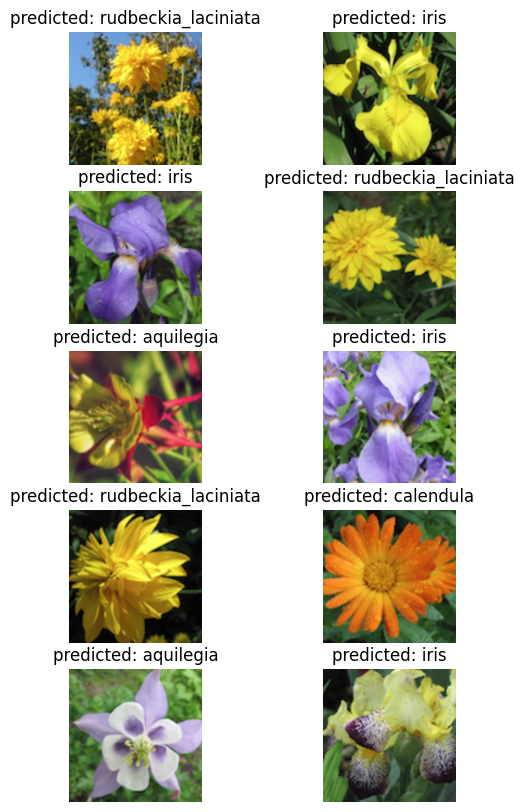

In [36]:
#Выводим результат
visualize_model(model_ft)

In [53]:
#Скачиваем претренированную модель
model_conv = torchvision.models.resnet18(pretrained=True)
#Отключаем обучение для всех весов кроме последнего
for param in model_conv.parameters():
    param.requires_grad = False
#Размер выходного вектора фитчей
num_ftrs = model_conv.fc.in_features
#Линейный слой до количества классов на выходе
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
#Если можем, то включаем cuda
model_conv = model_conv.to(device)
#Функция ошибки
criterion = nn.CrossEntropyLoss()
#Опитимайзер
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#Изменение скорости обучения (уменьшаем в 10 раз каждые 7 эпох)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [54]:
#Тренеруем модель
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2438 Acc: 0.2389
val Loss: 1.8279 Acc: 0.5333

Epoch 1/24
----------
train Loss: 1.5715 Acc: 0.4944
val Loss: 1.0849 Acc: 0.7000

Epoch 2/24
----------
train Loss: 1.1072 Acc: 0.6778
val Loss: 0.7661 Acc: 0.7333

Epoch 3/24
----------
train Loss: 0.9338 Acc: 0.7000
val Loss: 0.6548 Acc: 0.8333

Epoch 4/24
----------
train Loss: 0.8362 Acc: 0.7389
val Loss: 0.5180 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.8214 Acc: 0.7611
val Loss: 0.4445 Acc: 0.8667

Epoch 6/24
----------
train Loss: 0.6121 Acc: 0.8167
val Loss: 0.3784 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.5466 Acc: 0.8611
val Loss: 0.4257 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4912 Acc: 0.9333
val Loss: 0.3656 Acc: 0.9333

Epoch 9/24
----------
train Loss: 0.4484 Acc: 0.9389
val Loss: 0.4185 Acc: 0.9333

Epoch 10/24
----------
train Loss: 0.5290 Acc: 0.9000
val Loss: 0.4303 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.5387 Acc: 0.8833
val Loss: 0.3776 Acc: 0.9000

Ep

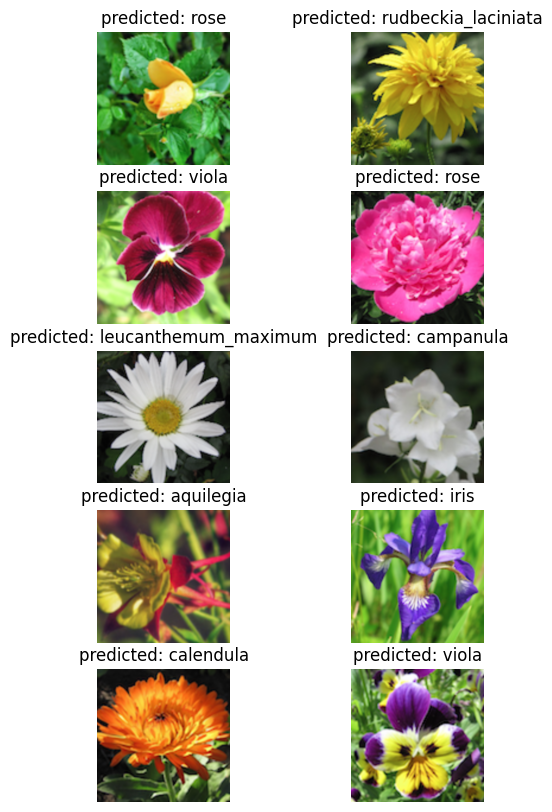

In [58]:
#Выводим результат
visualize_model(model_conv)